In [2]:
!pip install kaggle
!mkdir /root/.kaggle
!echo '{"username":"roknbae","key":"7e6c29161d21e99c37b20df1e006950a"}' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

In [3]:
import kaggle
kaggle.api.dataset_download_files('iammustafatz/diabetes-prediction-dataset', path='diabetes', unzip=True)


Dataset URL: https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset


In [4]:
df = pd.read_csv("/content/diabetes/diabetes_prediction_dataset.csv")

# 데이터 확인
print(df.head())
print(df.info())
print(df.describe())

   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age               

gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


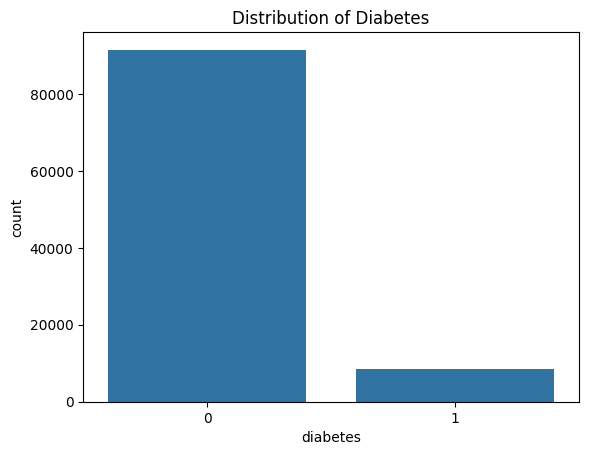

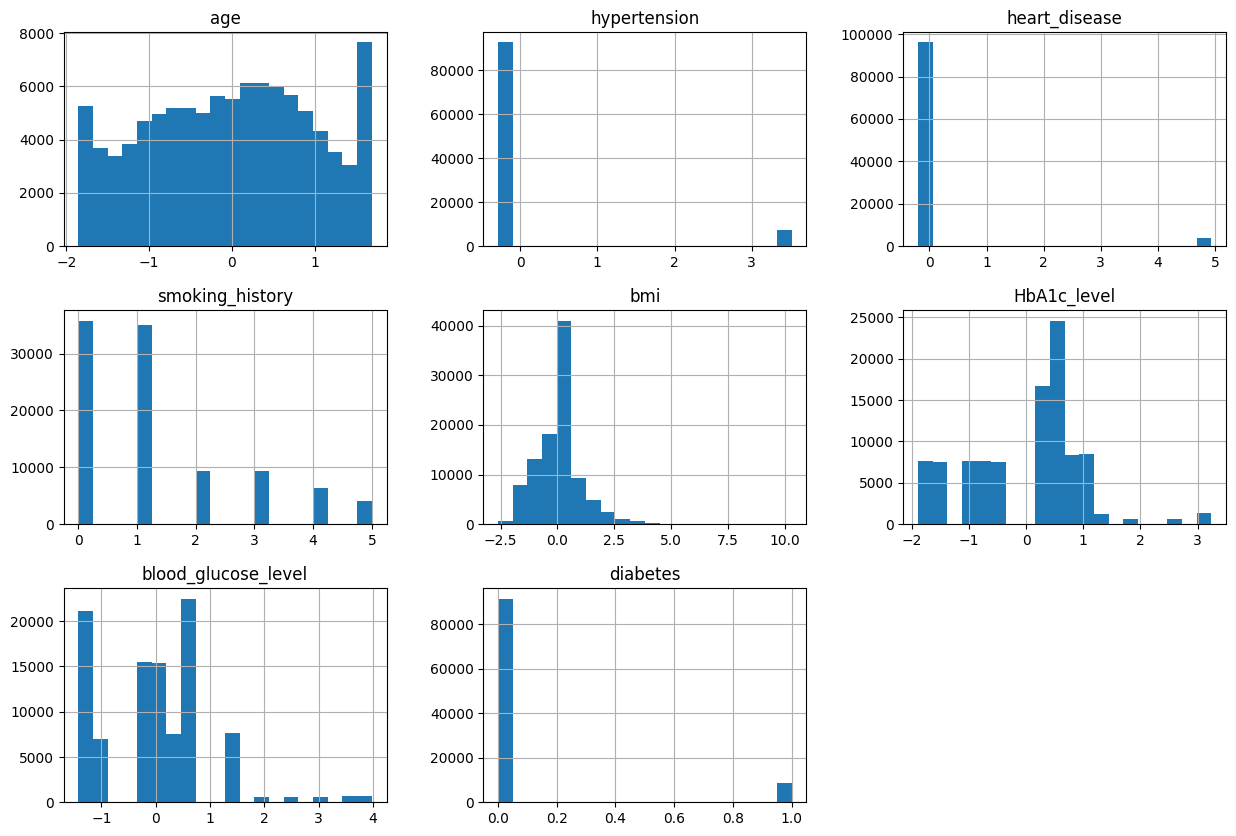

In [16]:
# 결측치 확인
print(df.isnull().sum())

# 성별과 흡연 경력 처리
df['gender'] = df['gender'].replace({'Male': 1, 'Female': 0})

# 흡연 경력 처리
df['smoking_history'] = df['smoking_history'].replace({
    'never': 0,
    'No Info': -1,
    'former': 1,
    'current': 2,
    'not current': 3,
    'ever': 4
})

# 범주형 데이터 인코딩
label_encoder = LabelEncoder()
df['smoking_history'] = label_encoder.fit_transform(df[['smoking_history']])


# 데이터 스케일링 (범주형 데이터는 제외하고 수치형 데이터만 스케일링)
numerical_features = df.drop(columns=['diabetes']).select_dtypes(include=[np.number]).columns
scaler = StandardScaler()
numerical_features = scaler.fit_transform(df[numerical_features])
df_scaled = pd.DataFrame(numerical_features)
df_scaled['diabetes'] = df['diabetes']

# 데이터 분포 시각화
sns.countplot(x='diabetes', data=df)
plt.title('Distribution of Diabetes')
plt.show()

# 각 특징의 분포 시각화
df.hist(bins=20, figsize=(15, 10))
plt.show()

In [14]:
df_scaled

,0,1,2,3,4,5,6
0,1.692704,-0.284439,4.936379,-0.195752,-0.321056,1.001706,0.047704
1,0.538006,-0.284439,-0.202578,-0.908483,-0.000116,1.001706,-1.426210
2,-0.616691,-0.284439,-0.202578,-0.195752,-0.000116,0.161108,0.489878
3,-0.261399,-0.284439,-0.202578,1.229711,-0.583232,-0.492690,0.416183
4,1.515058,3.515687,4.936379,1.229711,-1.081970,-0.679490,0.416183
...,...,...,...,...,...,...,...
99995,1.692704,-0.284439,-0.202578,-0.908483,-0.000116,0.628107,-1.180558
99996,-1.771388,-0.284439,-0.202578,-0.908483,-1.499343,0.908306,-0.934905
99997,1.070944,-0.284439,-0.202578,0.516980,0.076729,0.161108,0.416183
99998,-0.794336,-0.284439,-0.202578,-0.195752,1.220361,-1.426688,-0.934905


In [17]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

# 데이터 분할
X = df_scaled.drop(columns=['diabetes'])
y = df_scaled['diabetes']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 신경망 모델 정의
model = Sequential([
    Dense(16, input_dim=X_train.shape[1], activation='relu'),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/100
2000/2000 [==============================] - 7s 3ms/step - loss: 0.1461 - accuracy: 0.9502 - val_loss: 0.1166 - val_accuracy: 0.9584
Epoch 2/100
2000/2000 [==============================] - 5s 2ms/step - loss: 0.1135 - accuracy: 0.9604 - val_loss: 0.1124 - val_accuracy: 0.9601
Epoch 3/100
2000/2000 [==============================] - 6s 3ms/step - loss: 0.1085 - accuracy: 0.9624 - val_loss: 0.1071 - val_accuracy: 0.9621
Epoch 4/100
 602/2000 [========>.....................] - ETA: 2s - loss: 0.1093 - accuracy: 0.9617

KeyboardInterrupt: 

In [18]:
# Early Stopping 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 모델 재학습
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                    verbose=1, callbacks=[early_stopping])

# 학습 과정 시각화
plt.figure(figsize=(12, 8))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100
2000/2000 [==============================] - 5s 3ms/step - loss: 0.1000 - accuracy: 0.9650 - val_loss: 0.0989 - val_accuracy: 0.9654
Epoch 2/100
1958/2000 [============================>.] - ETA: 0s - loss: 0.0946 - accuracy: 0.9673

KeyboardInterrupt: 

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow.keras.optimizers'

In [23]:
# K-fold 설정
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 정의 함수
def create_model():
    model = Sequential([
        Dense(16, input_dim=X.shape[1], activation='relu'),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 데이터 분할
X = df.drop(columns=['diabetes'])
y = df['diabetes']

# 교차 검증을 통해 모델 학습
fold_no = 1
accuracy_per_fold = []
loss_per_fold = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    model = create_model()

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=1)

    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    accuracy_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    fold_no += 1

# 각 fold의 성능을 출력
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(accuracy_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {accuracy_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(accuracy_per_fold)} (+- {np.std(accuracy_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')


NameError: name 'Adam' is not defined

In [ ]:
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras.layers import Dropout

def create_regularized_model():
    model = Sequential([
        Dense(16, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(8, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 모델 정의 및 학습
regularized_model = create_regularized_model()
history_reg = regularized_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                                    verbose=1, callbacks=[early_stopping])

# 학습 과정 시각화
plt.figure(figsize=(12, 8))
plt.plot(history_reg.history['loss'], label='Training Loss')
plt.plot(history_reg.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()